### Libs

In [1]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Base vars

In [2]:
PATH_ROOT = 'beeVSwasp/'

BATCH_SIZE = 32

IMG_WEIGHT = IMG_HEIGHT = 180

N_CLASSES = 2

KERNEL_SIZE = 3
EPOCHS = 5

### Spliting data

In [3]:
data_dir = pathlib.Path(PATH_ROOT)

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WEIGHT),
    batch_size=BATCH_SIZE
)

Found 4596 files belonging to 2 classes.
Using 3677 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WEIGHT),
    batch_size=BATCH_SIZE
)

Found 4596 files belonging to 2 classes.
Using 919 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['bee', 'wasp']


### Viewing data

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(image_batch.numpy().max())
    break

(32, 180, 180, 3)
(32,)
255.0


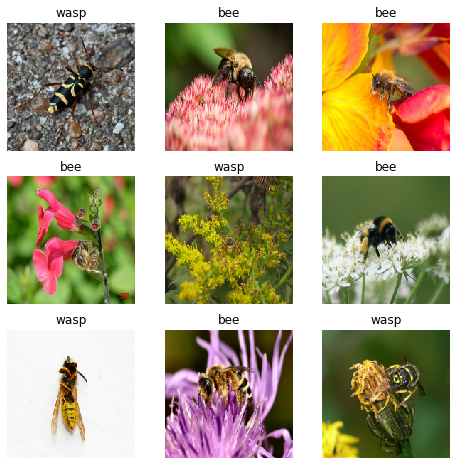

In [8]:
plt.figure(figsize=(8, 8))
for img, lbls in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[lbls[i]])
        plt.axis('off')

### Performance increase

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create and compile model

In [10]:
m_conv2dSequential = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)), # normalization cannels
    
    layers.Conv2D(filters=16, kernel_size=KERNEL_SIZE, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(), # in 1d array for dense
    layers.Dense(units=256, activation='relu'),
    layers.Dense(N_CLASSES)
]) # Sequential

m_conv2dSequential.compile(
    optimizer='nadam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

m_conv2dSequential.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Fitting model

In [11]:
history = m_conv2dSequential.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
115/115 [==============================] - 87s 709ms/step - loss: 0.8516 - accuracy: 0.6130 - val_loss: 0.6288 - val_accuracy: 0.6746
Epoch 2/5
115/115 [==============================] - 78s 682ms/step - loss: 0.5382 - accuracy: 0.7392 - val_loss: 0.4428 - val_accuracy: 0.8215
Epoch 3/5
115/115 [==============================] - 78s 676ms/step - loss: 0.4949 - accuracy: 0.7673 - val_loss: 0.4572 - val_accuracy: 0.7889
Epoch 4/5
115/115 [==============================] - 79s 685ms/step - loss: 0.3809 - accuracy: 0.8280 - val_loss: 0.4006 - val_accuracy: 0.8237
Epoch 5/5
115/115 [==============================] - 79s 691ms/step - loss: 0.2817 - accuracy: 0.8910 - val_loss: 0.4419 - val_accuracy: 0.8335


### View metrics and results

Text(0.5, 1.0, 'Train and Val Accuracy')

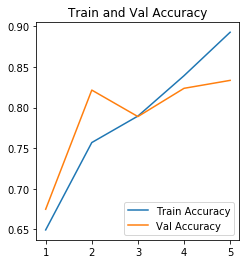

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), acc, label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Val Accuracy')

In [13]:
val_pred_lbls = np.argmax(m_conv2dSequential.predict(val_ds), axis=-1)

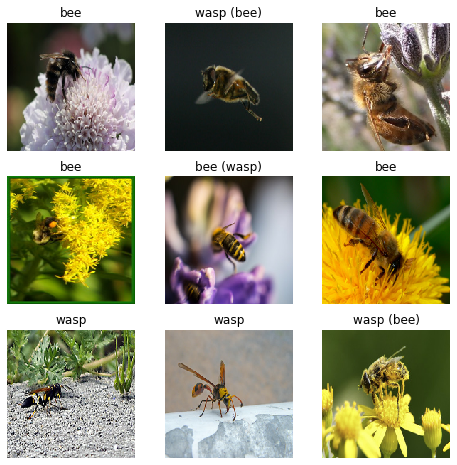

In [14]:
plt.figure(figsize=(8, 8))

for val_img, val_true_lbls in val_ds.take(1):
    for i in range(9):
        
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(val_img[i].numpy().astype('uint8'))
        
        true_lbl = class_names[val_true_lbls[i]]
        pred_lbl = class_names[val_pred_lbls[i]]
        
        if true_lbl == pred_lbl:
            plt.title(pred_lbl)
        else:
            plt.title(f'{pred_lbl} ({true_lbl})')
        
        plt.axis('off')

### P.S. Чисто на tenserflow без обращения ко вложенному keras пока не понимаю как писать, сам только учусь, по это делаю по шаблону.